In [8]:
import os
from functools import partial
import json
import csv

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import random
import seaborn as sns

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

In [56]:
data = pd.read_csv("./Outputs/texas_data100.csv")

In [101]:
data["seats"].describe()

count    48.0
mean     27.0
std       0.0
min      27.0
25%      27.0
50%      27.0
75%      27.0
max      27.0
Name: seats, dtype: float64

In [100]:
rep_data["seats"].describe()

count    27.0
mean     28.0
std       0.0
min      28.0
25%      28.0
50%      28.0
75%      28.0
max      28.0
Name: seats, dtype: float64

In [91]:
dem_data["seats"].describe()

count    73.000000
mean     26.657534
std       0.477818
min      26.000000
25%      26.000000
50%      27.000000
75%      27.000000
max      27.000000
Name: seats, dtype: float64

In [99]:
dem_data["seats"].describe()

count    25.0
mean     26.0
std       0.0
min      26.0
25%      26.0
50%      26.0
75%      26.0
max      26.0
Name: seats, dtype: float64

In [94]:
dem_data = dem_data.set_index("seats")

In [71]:
# data = data.set_index("seats")
# rep_data = data
# dem_data = data

rep_data = rep_data.drop(26, axis=0)
rep_data = rep_data.drop(27, axis=0)
dem_data = dem_data.drop(27, axis=0)
dem_data = dem_data.drop(28, axis=0)
data = data.drop(26, axis=0)
data = data.drop(28, axis=0)


# data = data.drop(26, axis = 0)

KeyError: '[27] not found in axis'

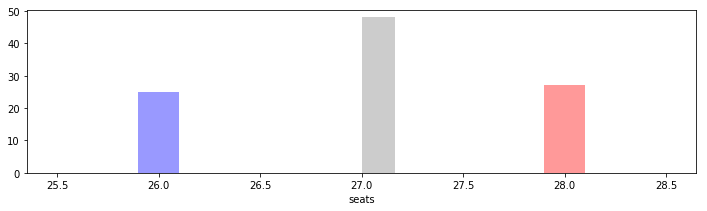

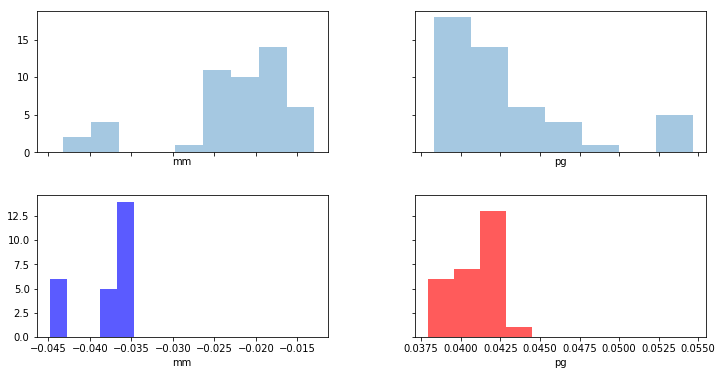

In [108]:
fig, seats = plt.subplots(figsize=(12,3))
fig, ax = plt.subplots(2,2, figsize = (12,6), sharex="col", sharey="row")

plt.subplots_adjust(wspace=0.3, hspace=0.3)

sns.distplot(data["seats"], color="gray", ax = seats, kde=False)
sns.distplot(dem_data["seats"], color="blue", ax = seats, kde=False)
sns.distplot(rep_data["seats"], color="red", ax = seats, kde=False)

sns.distplot(data["mm"], ax = ax[0,0], kde=False)
sns.distplot(data["pg"], ax = ax[0,1], kde=False)

sns.distplot(dem_data["mm"], color="blue", ax = ax[1,0], kde=False)
sns.distplot(rep_data["pg"], color="red",ax = ax[1,1], kde=False)
sns.distplot(dem_data["mm"], color="blue",ax = ax[1,0], kde=False)
sns.distplot(rep_data["pg"], color="red",ax = ax[1,1], kde=False)

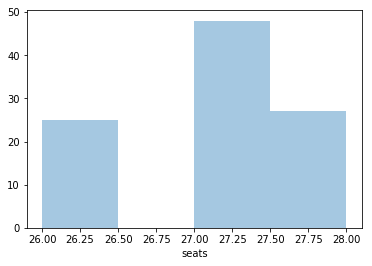

In [13]:
sns.distplot(data["seats"], kde=False)

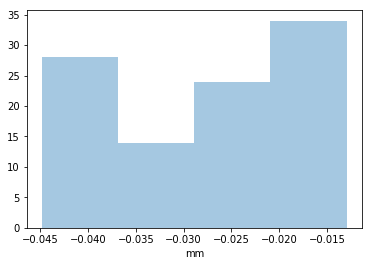

In [14]:
sns.distplot(data["mm"], kde=False)

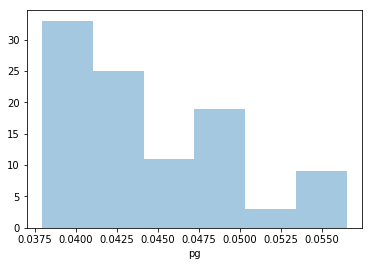

In [15]:
sns.distplot(data["pg"], kde=False)